<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# This loads some custom styles for matplotlib
import json, matplotlib

with open("assets/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

np.random.seed(
    42
)  # This makes our random numbers reproducable when the notebook is rerun in order

## Making some measurments 

So now that we have the ability to simulate our system lets do a little exploration. First let's take three temperatures at each we'll do 10 runs and see how the systems evolve. I'll also tack on a little histogram at the right hand side of where the systens spent their time.

In [2]:
from MCFF.mcmc import mcmc_generator

### The measurement we will make ###
def average_color(state):
    return np.mean(state)


### Simulation Inputs ###
N = 20  # Use an NxN system
Ts = [10, 4.5, 3]  # What temperatures to use
steps = 200  # How many times to sample the state
stepsize = N**2  # How many individual monte carlo flips to do in between each sample
N_repeats = 10  # How many times to repeat each run at fixed temperature
initial_state = np.ones(shape=(N, N))  # the intial state to use
flips = (
    np.arange(steps) * stepsize
)  # Use this to plot the data in terms of individual flip attemps

### Simulation Code ###
average_color_data = np.array(
    [
        [
            [
                average_color(s)
                for s in mcmc_generator(
                    initial_state, steps=steps, stepsize=stepsize, T=T
                )
            ]
            for _ in range(N_repeats)
        ]
        for T in Ts
    ]
)

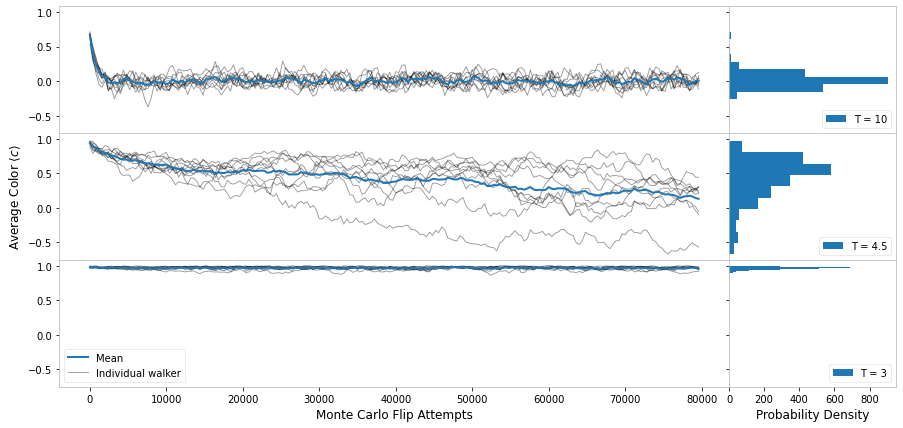

In [3]:
# It's always good to separate you plotting from your data generation
from itertools import count

fig, axes = plt.subplots(
    figsize=(15, 7),
    nrows=3,
    ncols=2,
    sharey="all",
    sharex="col",
    gridspec_kw=dict(hspace=0, wspace=0, width_ratios=(4, 1)),
)

for i, ax, hist_ax in zip(count(), axes[:, 0], axes[:, 1]):
    c = average_color_data[i]
    indiv_line, *_ = ax.plot(flips, c.T, alpha=0.4, color="k", linewidth=0.9)
    (mean_line,) = ax.plot(flips, np.mean(c, axis=0))
    hist_ax.hist(c.flatten(), orientation="horizontal", label=f"T = {Ts[i]}")

axes[-1, 0].set(xlabel=f"Monte Carlo Flip Attempts")
axes[-1, 1].set(xlabel="Probability Density")
axes[1, 0].set(ylabel=r"Average Color $\langle c \rangle$")
axes[-1, 0].legend([mean_line, indiv_line], ["Mean", "Individual walker"])
for ax in axes[:, 1]:
    ax.legend(loc=4)

There are a few key takeaways about MCMC in this plot:

- It takes a while for MCMC to 'settle in', you can see that for T = 10 the natural state is somewhere around c = 0, which takes about 2000 steps to reach from the initial state with c = 1. In general when doing MCMC we want to throw away some of the values at the beginging because they're too affected by the initial state.
- At High and Low temperatures the we basically just get small fluctuations about an average value
- At intermediate temperature the fluctuations occur on much longer time scales! Because the systems can only move a little bit each timestep, it means that the measurements we are making are *correlated* with themselves at previous times. The result of this is that if we use MCMC to draw N samples, we don't get as much information as if we had drawn samples from an uncorrelated variable (like a die roll for instance).

## Average Color and 'Susceptability'




In [4]:
### The measurement we will make ###
def average_color(state):
    return np.mean(state)


### Simulation Inputs ###
Ns = np.array(
    [
        30,
    ]
)  # Use an NxN system
Ts = np.linspace(4, 5.5, 20)  # What temperatures to use
steps = 1000  # How many times to sample the state
stepsize = (
    lambda N: N**2
)  # How many individual monte carlo flips to do in between each sample
N_repeats = 2  # How many times to repeat each run at fixed temperature

### Simulation Code ###
average_color_data = np.array(
    [
        [
            [
                [
                    average_color(s)
                    for s in mcmc_generator(
                        np.ones(shape=(N, N)), steps=steps, stepsize=stepsize(N), T=T
                    )
                ]
                for _ in range(N_repeats)
            ]
            for T in Ts
        ]
        for N in Ns
    ]
)

In [5]:
mean_color = np.mean(average_color_data, axis=(-2, -1))
color_susceptability = np.std(average_color_data, axis=-1).mean(axis=-1)

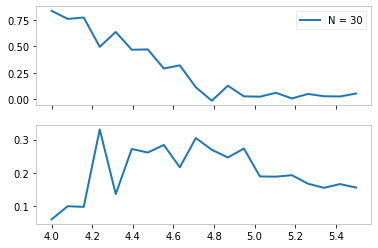

In [6]:
fig, axes = plt.subplots(nrows=2, sharex="col")

for i, N in enumerate(Ns):
    axes[0].plot(Ts, mean_color[i], label=f"N = {N}")
    axes[1].plot(Ts, color_susceptability[i])

axes[0].legend()

In [7]:
### try combining mpiere, itertools.product and xarray